In [1]:
import math
import numpy as np

from lab1_tools import *
from lab1_proto import *

from matplotlib import pyplot as plt
from scipy import signal
from scipy import fftpack


In [2]:
data = np.load('lab1_data.npz', allow_pickle=True)['data']
example = np.load('lab1_example.npz', allow_pickle=True)['example'].item()

In [3]:
indices_o = [index for index, element in enumerate(data) if element["digit"] == 'o']
indices_z = [index for index, element in enumerate(data) if element["digit"] == 'z']
indices_1 = [index for index, element in enumerate(data) if element["digit"] == '1']
indices_2 = [index for index, element in enumerate(data) if element["digit"] == '2']
indices_3 = [index for index, element in enumerate(data) if element["digit"] == '3']
indices_4 = [index for index, element in enumerate(data) if element["digit"] == '4']
indices_5 = [index for index, element in enumerate(data) if element["digit"] == '5']
indices_6 = [index for index, element in enumerate(data) if element["digit"] == '6']
indices_7 = [index for index, element in enumerate(data) if element["digit"] == '7']
indices_8 = [index for index, element in enumerate(data) if element["digit"] == '8']
indices_9 = [index for index, element in enumerate(data) if element["digit"] == '9']
print("Indices of oh:", indices_o)
print("Indices of zero:", indices_z)
print("Indices of one:", indices_1)
print("Indices of two:", indices_2)
print("Indices of three:", indices_3)
print("Indices of four:", indices_4)
print("Indices of five:", indices_5)
print("Indices of six:", indices_6)
print("Indices of seven:", indices_7)
print("Indices of eight:", indices_8)
print("Indices of nine:", indices_9)

Indices of oh: [0, 1, 22, 23]
Indices of zero: [2, 3, 24, 25]
Indices of one: [4, 5, 26, 27]
Indices of two: [6, 7, 28, 29]
Indices of three: [8, 9, 30, 31]
Indices of four: [10, 11, 32, 33]
Indices of five: [12, 13, 34, 35]
Indices of six: [14, 15, 36, 37]
Indices of seven: [16, 17, 38, 39]
Indices of eight: [18, 19, 40, 41]
Indices of nine: [20, 21, 42, 43]


In [4]:
samples = example['samples']

In [5]:
# CONST
# window length of 20 ms and shift of 10 ms
winlen = int(example['samplingrate'] * 0.02)
winshift = int(example['samplingrate'] * 0.01)

# Enframe

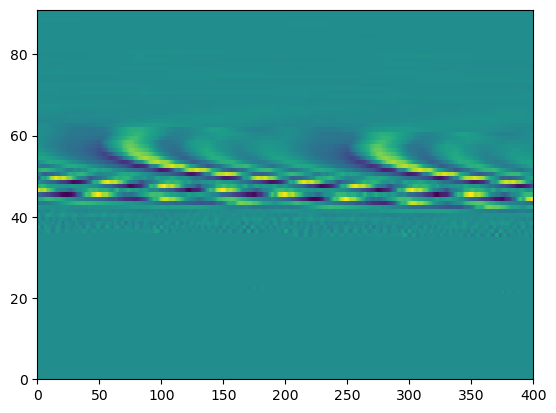

In [6]:
enframed = enframe(samples, winlen, winshift)
plt.pcolormesh(enframed)
plt.show()

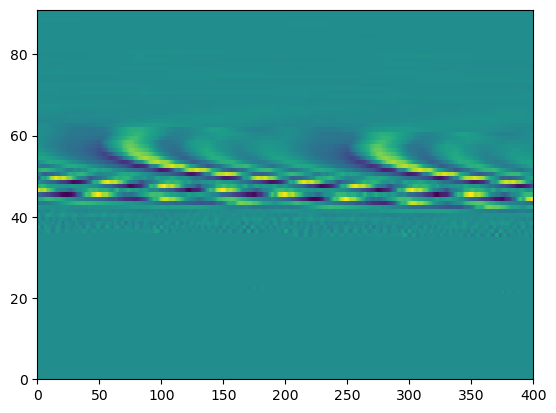

In [7]:
#check
plt.pcolormesh(example['frames'])
plt.show()

# Pre-emphasis

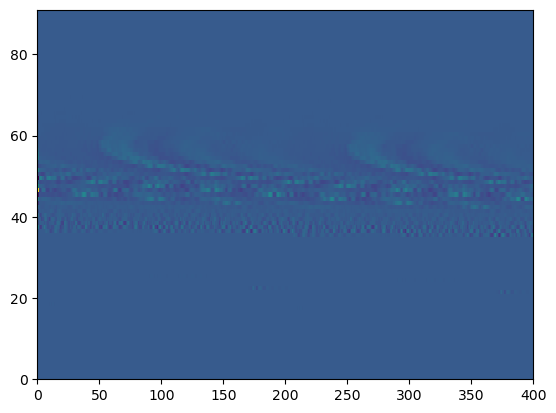

In [8]:
pre_emphasized = preemp(enframed)
plt.pcolormesh(pre_emphasized)
plt.show()

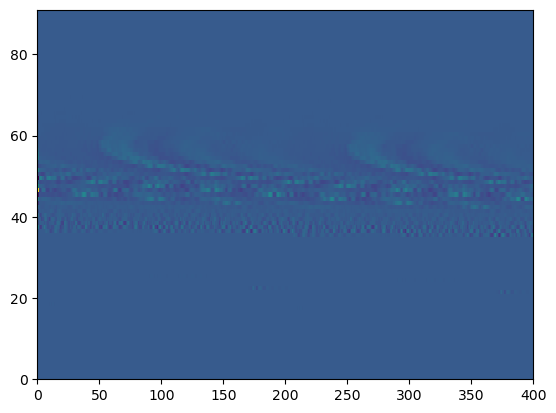

In [9]:
#check
plt.pcolormesh(example['preemph'])
plt.show()

# Hamming Window

/var/folders/n_/69h6zl_11r11127mr1z3n6zw0000gn/T/ipykernel_19649/312804029.py:1: DeprecationWarning: Importing hamming from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hamming' or the convenience function 'scipy.signal.get_window' instead.
  ham_window = signal.hamming(len(pre_emphasized[0]),sym=False)


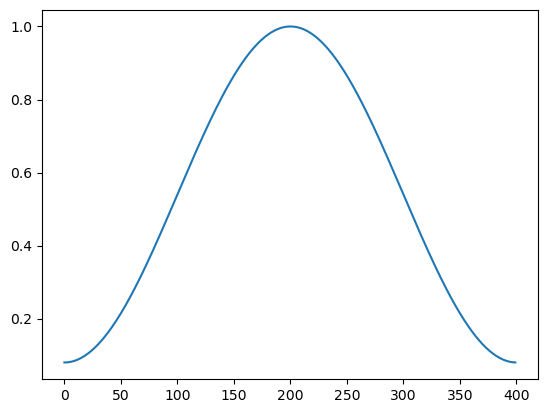

In [10]:
ham_window = signal.hamming(len(pre_emphasized[0]),sym=False)
plt.plot(ham_window)
plt.show()

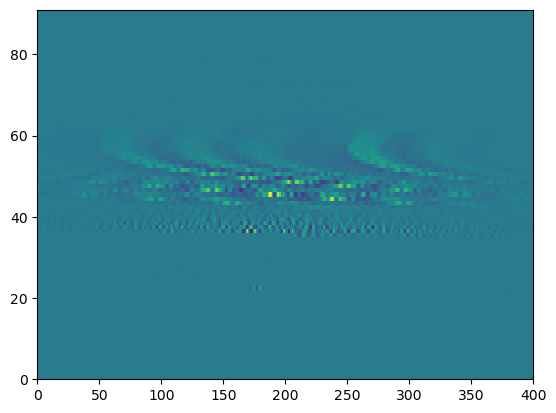

In [11]:
windowed = windowing(pre_emphasized)
plt.pcolormesh(windowed)
plt.show()

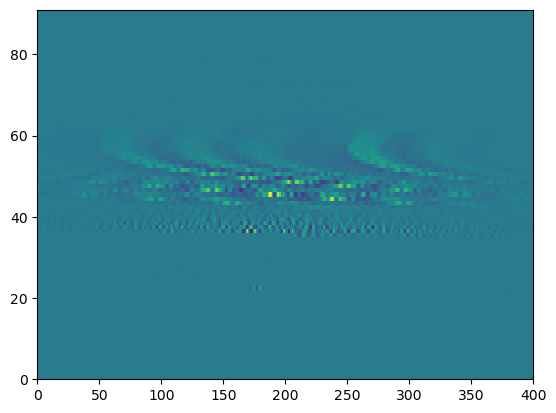

In [12]:
#check
plt.pcolormesh(example['windowed'])
plt.show()

# Fast Fourier Transform

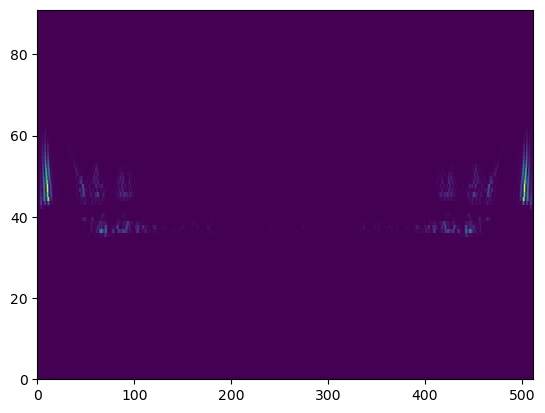

In [13]:
FFT = powerSpectrum(windowed, 512)
plt.pcolormesh(FFT)
plt.show()

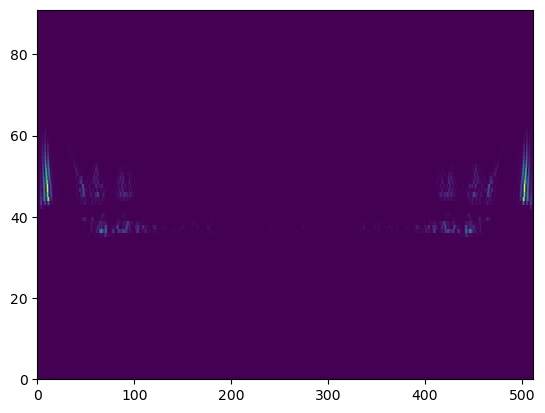

In [14]:
#check
plt.pcolormesh(example['spec'])
plt.show()

# Mel filterbank log spectrum

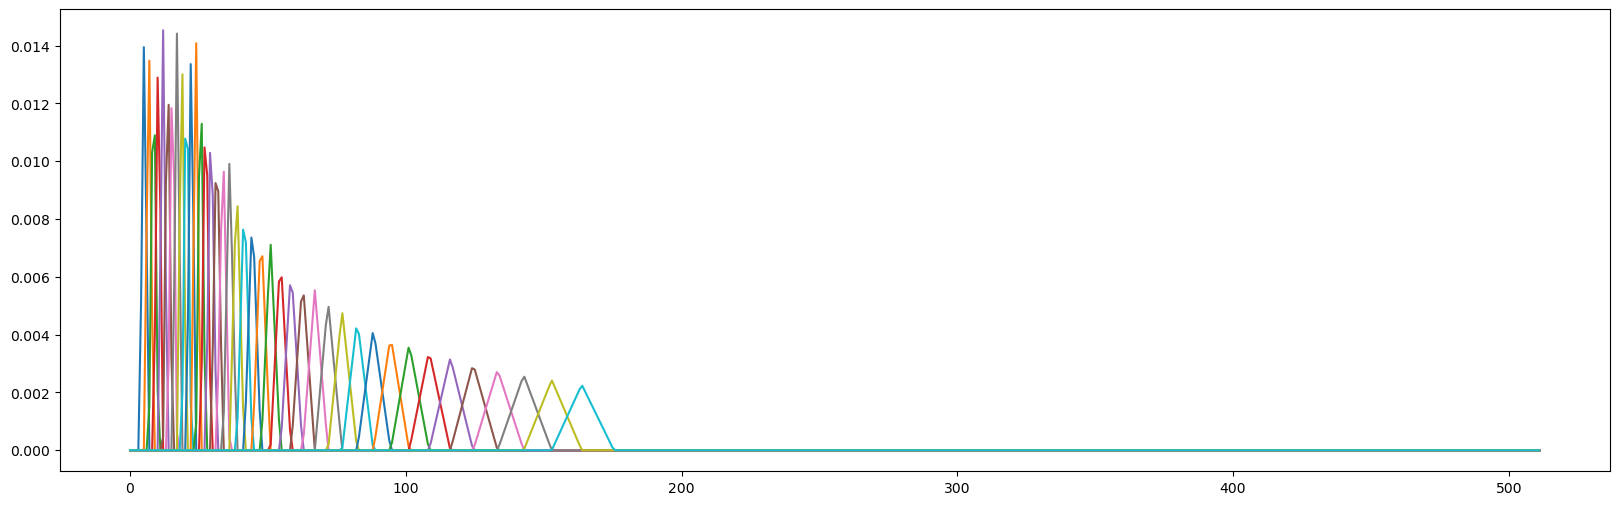

In [15]:
plt.figure(figsize=(20, 6))
Y = trfbank(example['samplingrate'], 512)
Y = Y.transpose()
Y.shape
X = []
for i in range(512):
    X.append(i)
plt.plot(X,Y)
plt.show()

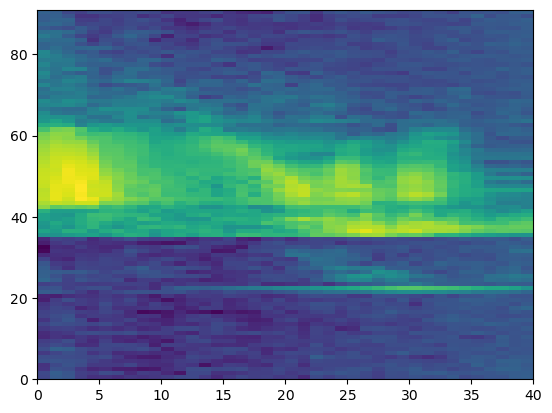

In [16]:
Mspec = logMelSpectrum(FFT, example['samplingrate'])
plt.pcolormesh(Mspec)
plt.show()

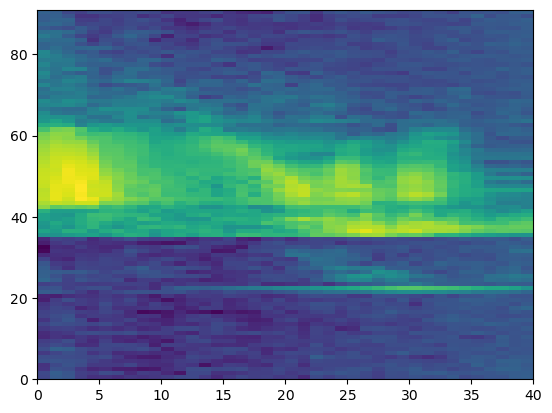

In [17]:
#check
plt.pcolormesh(example['mspec'])
plt.show()

# Cosine Transofrm and Liftering

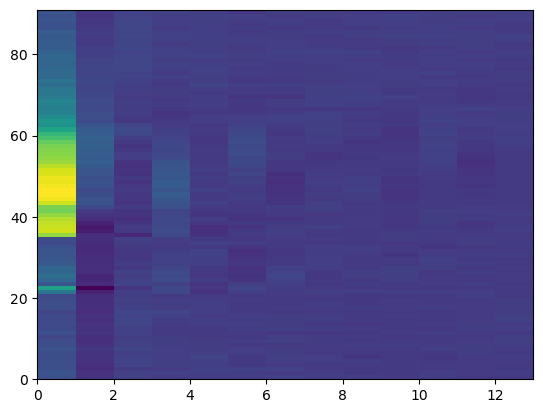

In [18]:
Mfcc = cepstrum(Mspec, 13)
plt.pcolormesh(Mfcc)
plt.show()

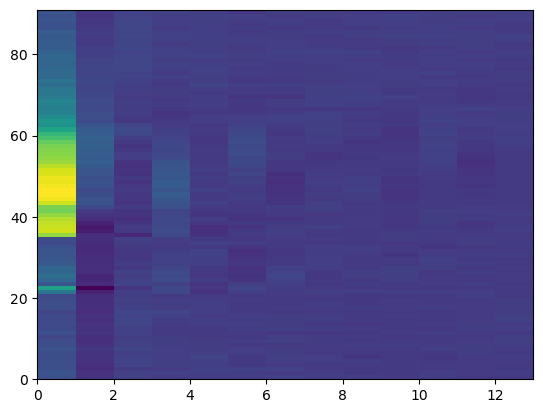

In [19]:
#check
plt.pcolormesh(example['mfcc'])
plt.show()

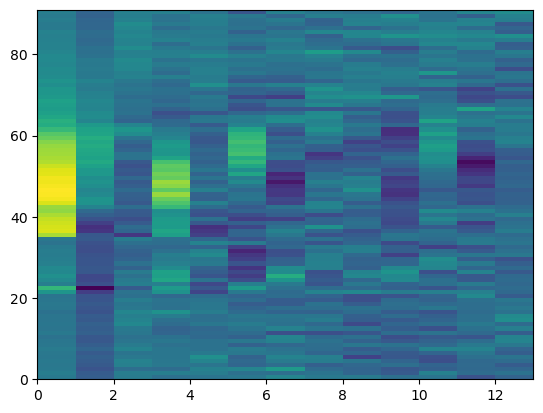

In [20]:
Lmfcc = lifter(Mfcc)
plt.pcolormesh(Lmfcc)
plt.show()

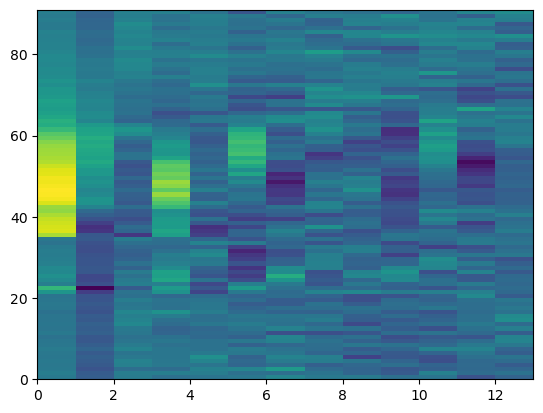

In [21]:
#check
plt.pcolormesh(example['lmfcc'])
plt.show()

# The liftered MFCCs for the utterances in the data array

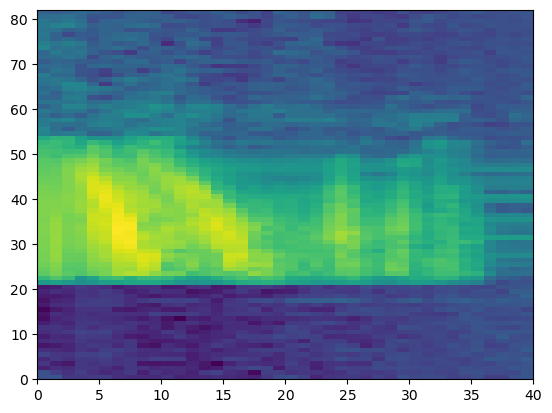

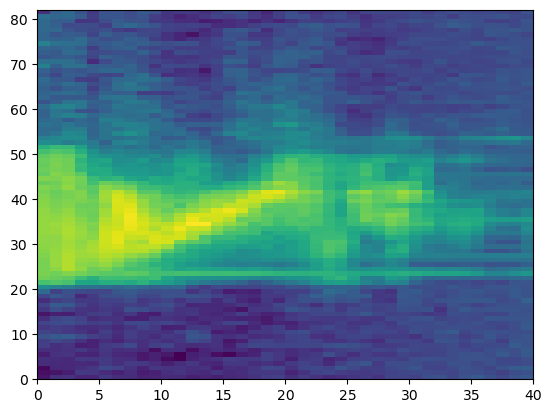

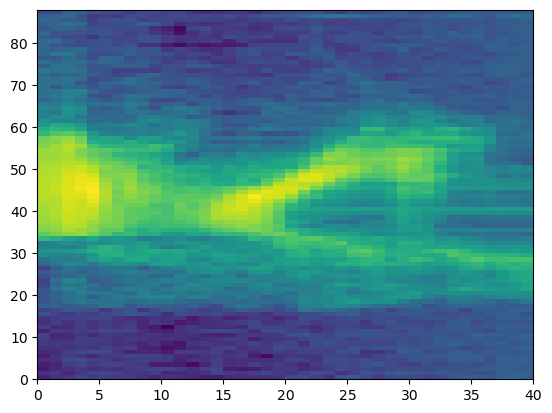

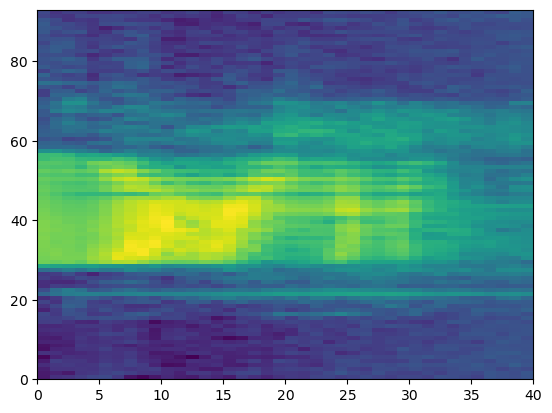

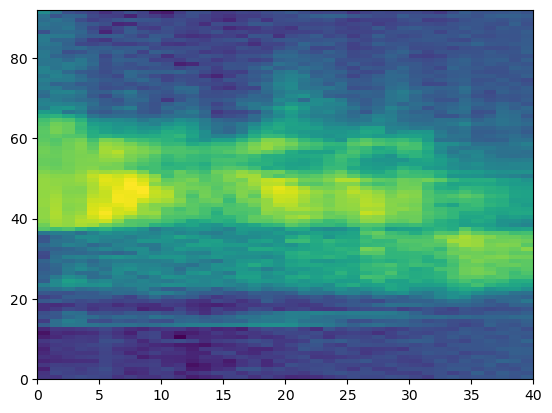

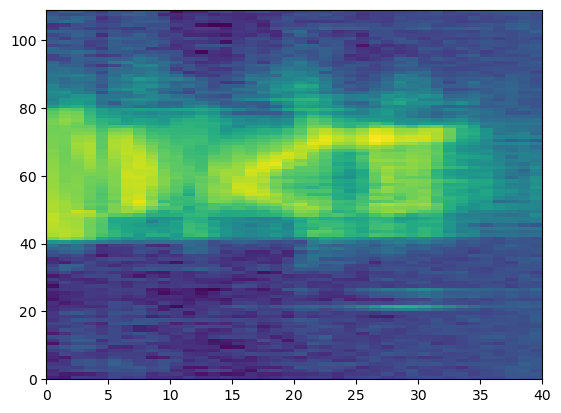

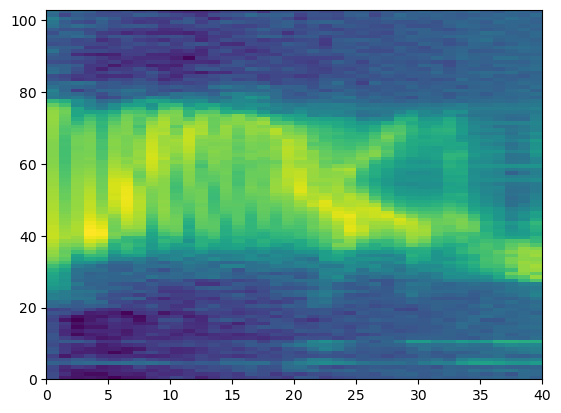

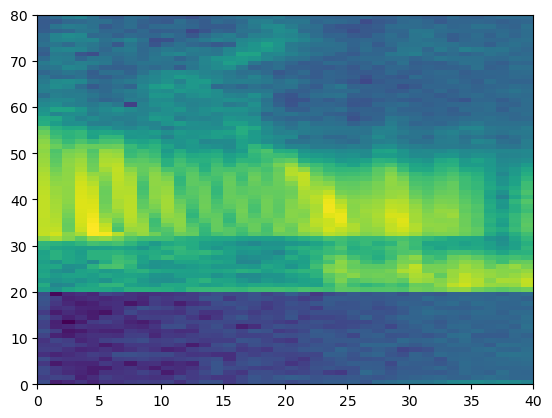

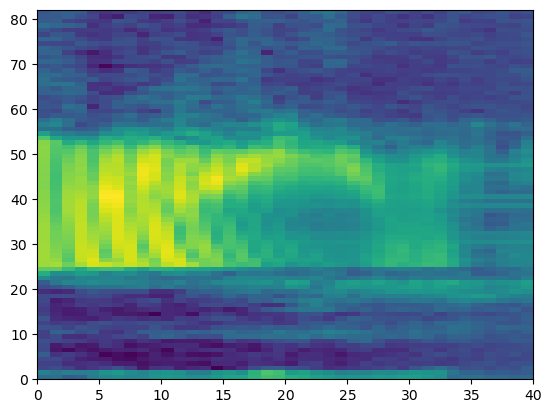

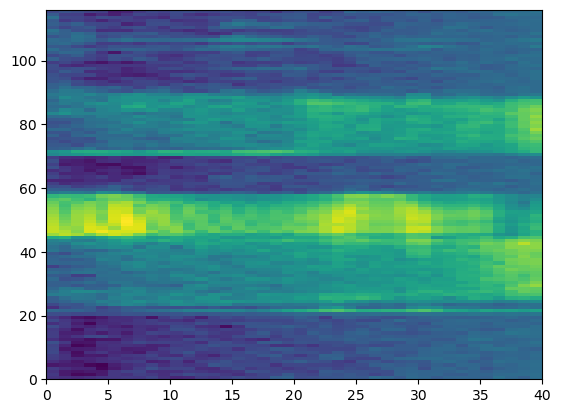

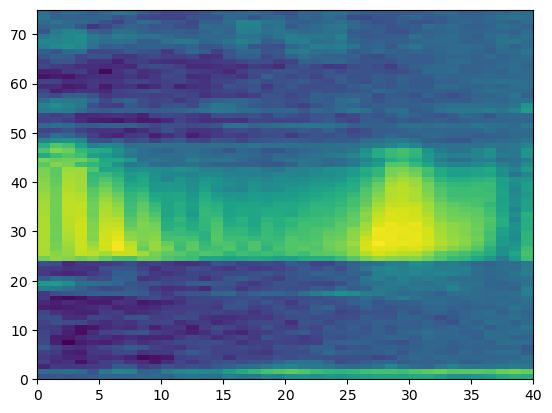

In [22]:
for i in range(0, len(data), 4):
    result = mspec(data[i]['samples'])
    plt.pcolormesh(result)
    plt.show()

# Feature Correlation

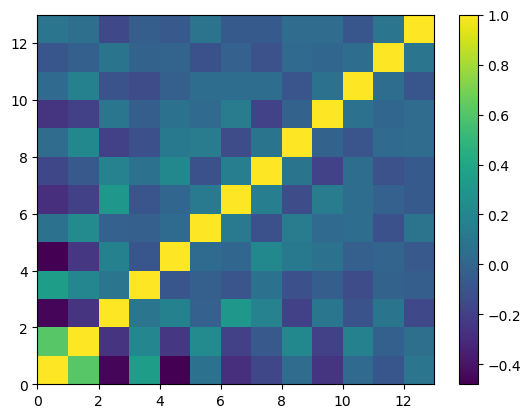

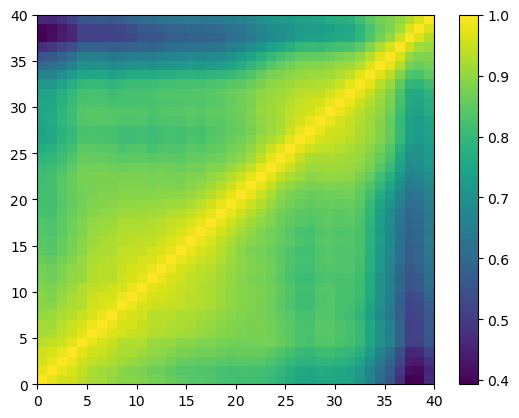

In [23]:
mfcc_utterances = []
mspec_utterances = []
for samples in data:
    mfcc_utterances.append(mfcc(samples["samples"])) # shape: 44 * (N * 13)
    mspec_utterances.append(mspec(samples["samples"])) # shape: 44 * (N * 40)

concatenated_mfcc = np.vstack(mfcc_utterances)
concatenated_mspec = np.vstack(mspec_utterances)
corr_mfcc = np.corrcoef(concatenated_mfcc.T)
corr_mspec = np.corrcoef(concatenated_mspec.T)

plt.pcolormesh(corr_mfcc)
plt.colorbar()
plt.show()
plt.pcolormesh(corr_mspec)
plt.colorbar()
plt.show()

### Are features correlated? 
No. MFCCs are designed to be de-correlated, which means each coefficient should capture distinct aspects of the audio signal's spectrum, making them relatively independent of each other. This de-correlation is primarily achieved through the use of the Discrete Cosine Transform (DCT) in the final step of MFCC computation, which is similar to Principal Component Analysis (PCA) in its ability to produce uncorrelated features from a correlated set of data.

### Is the assumption of diagonal covariance matrices for Gaussian modelling justified?
Yes. Since MFCCs are designed to minimize correlation between features, the off-diagonal elements of the covariance matrix are assumed to be close to zero.

# Explore Speech Segments with Clustering

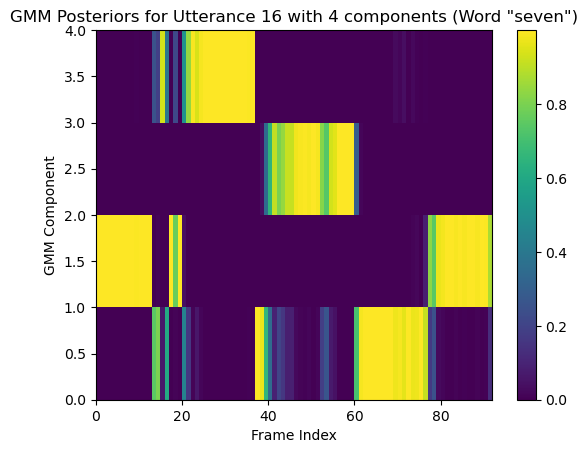

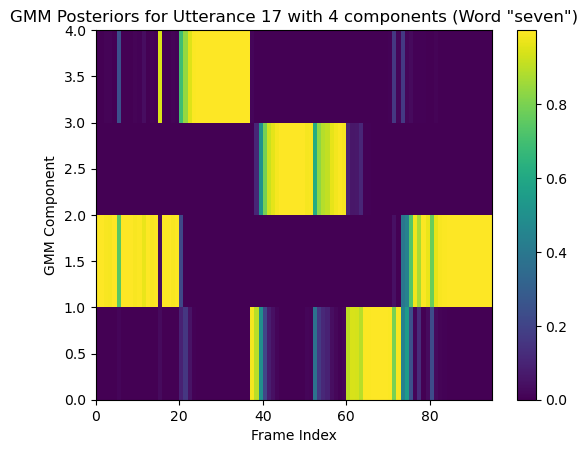

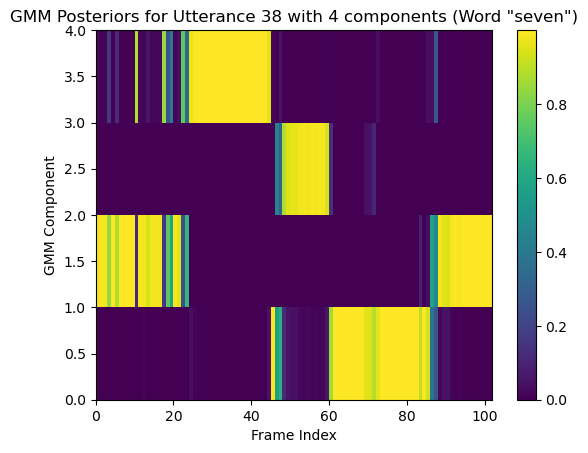

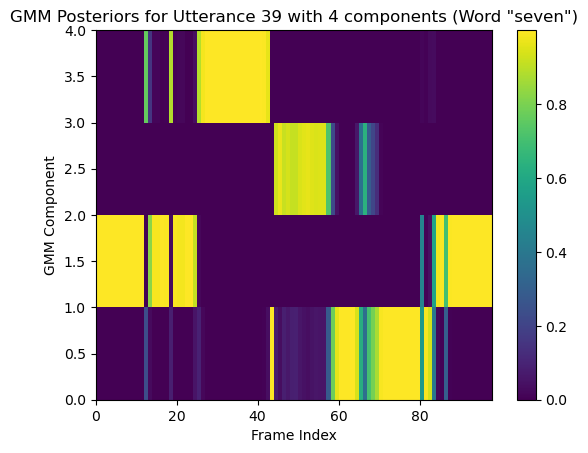

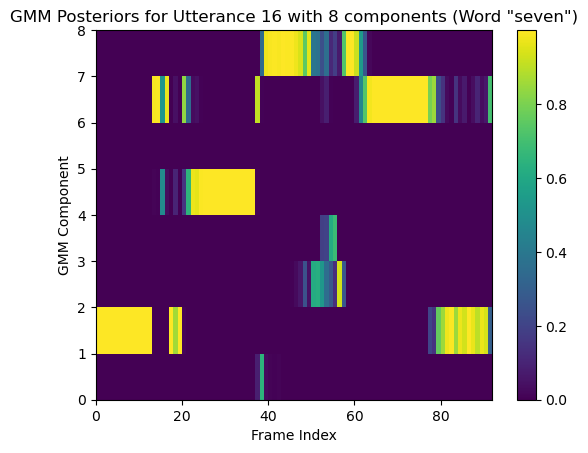

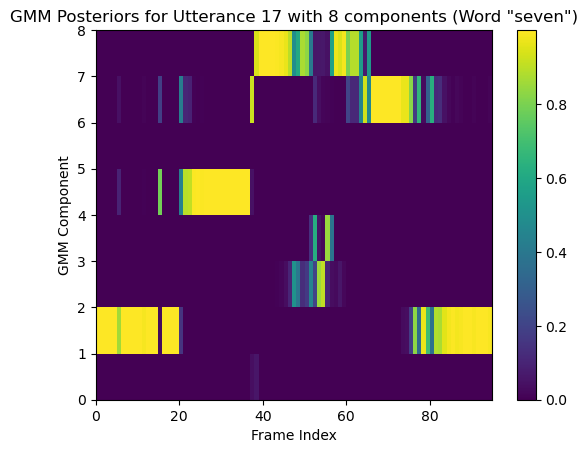

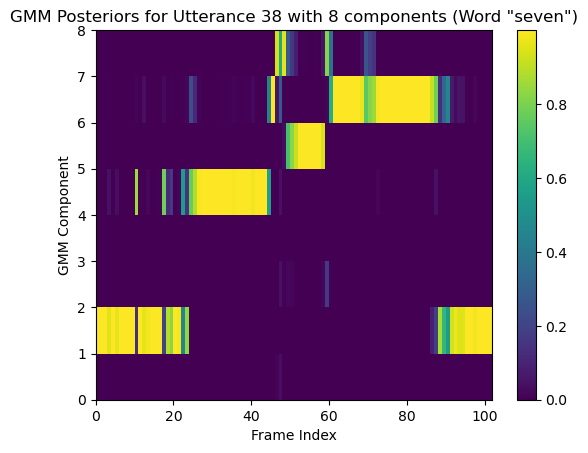

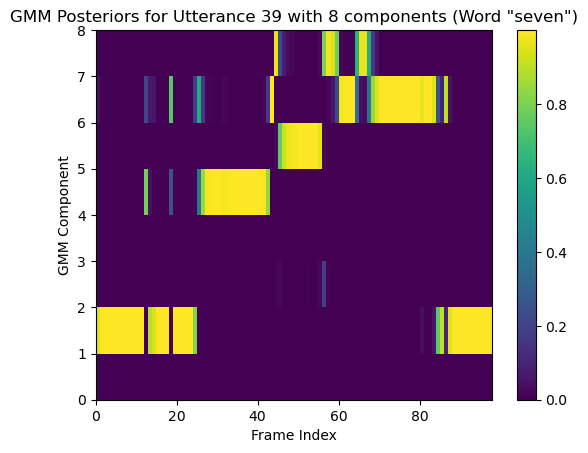

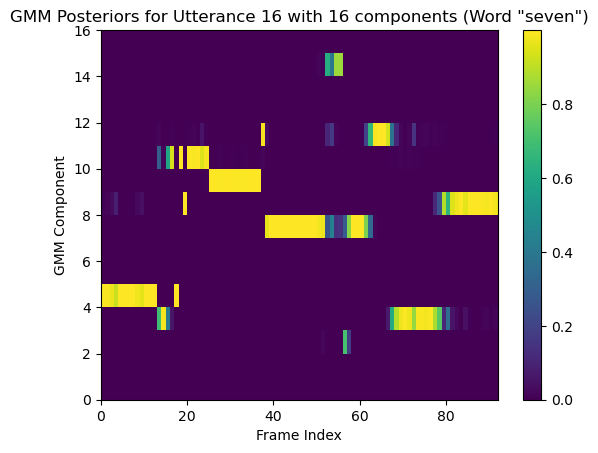

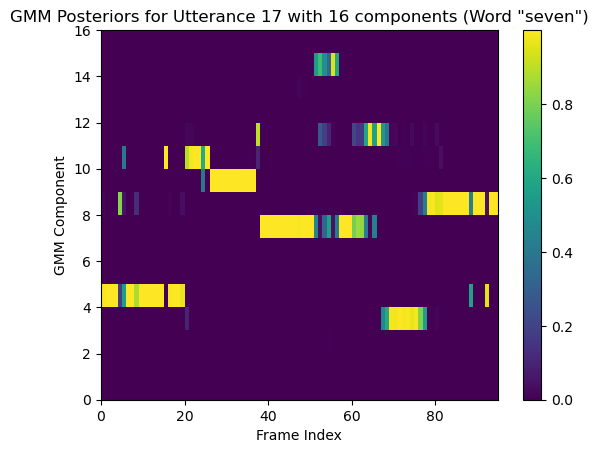

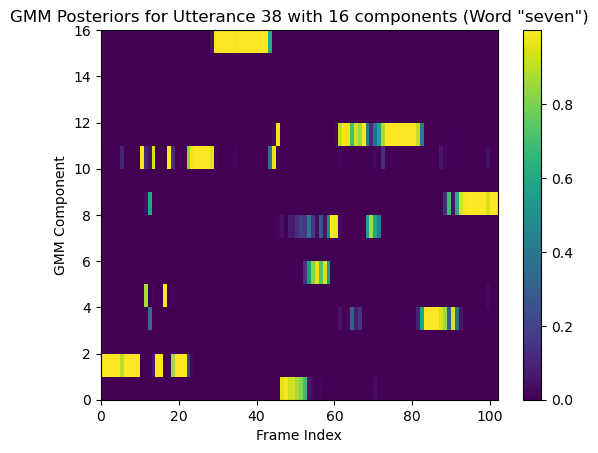

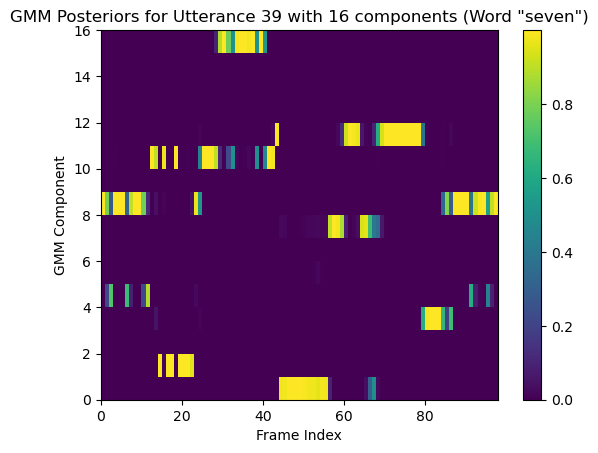

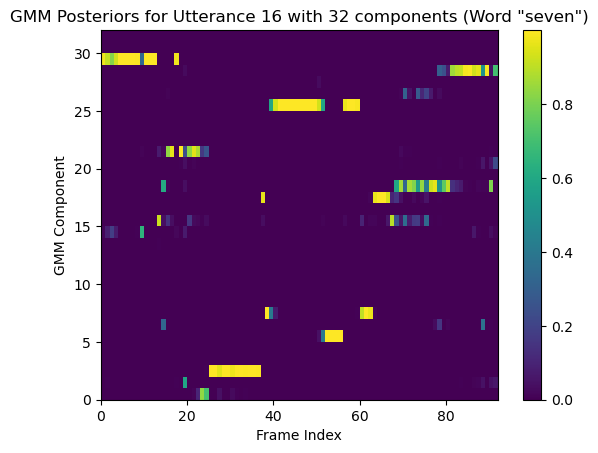

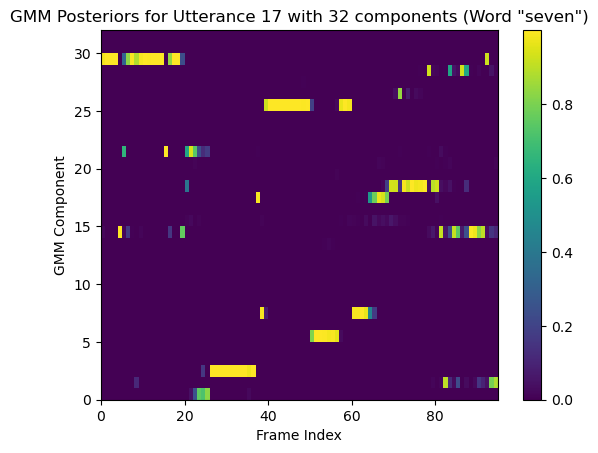

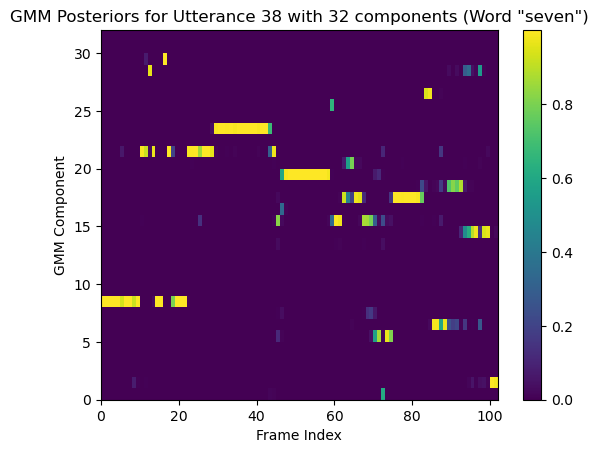

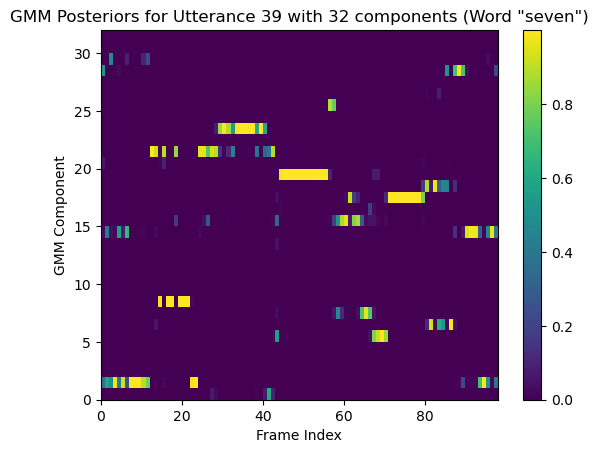

In [24]:
from sklearn.mixture import GaussianMixture

components = [4, 8, 16, 32]

gmm_models = {}
for n_components in components:
    gmm = GaussianMixture(n_components=n_components, covariance_type='diag', random_state=42)
    gmm.fit(concatenated_mfcc) 
    gmm_models[n_components] = gmm

# Select utterances for the word "seven" by their indices
utterance_indices = [16, 17, 38, 39]
utterance_features = [mfcc_utterances[i] for i in utterance_indices]

for n_components in components:
  gmm = gmm_models[n_components]
  for index in utterance_indices:
      posteriors = gmm.predict_proba(mfcc_utterances[index])
      plt.pcolormesh(posteriors.T)
      plt.colorbar()
      plt.title(f'GMM Posteriors for Utterance {index} with {n_components} components (Word "seven")')
      plt.ylabel('GMM Component')
      plt.xlabel('Frame Index')
      plt.show()

### Classes Discovered by Unsupervised Learning: 
The classes (GMM components) represent clusters in the feature space that the model has learned to distinguish. These may or may not correspond directly to phonemes, depending on how well the features capture distinctions relevant to different speech sounds and the variability within those sounds.

### Correspondence to Phonemes: 
The classes might roughly correspond to phonemes or groups of similar phonemes, especially if the MFCC features capture the relevant spectral properties of the speech signal. However, the correspondence isn't perfect due to the unsupervised nature of GMM and the complexity of speech sounds.

### Stability Across Different Speakers: 
The stability of these classes across different speakers depends on how speaker-independent the features are and how much variation the GMM can model. Some components may consistently represent specific phonemes across speakers, while others might capture speaker-specific or context-specific variations.



# Comparing Utterances

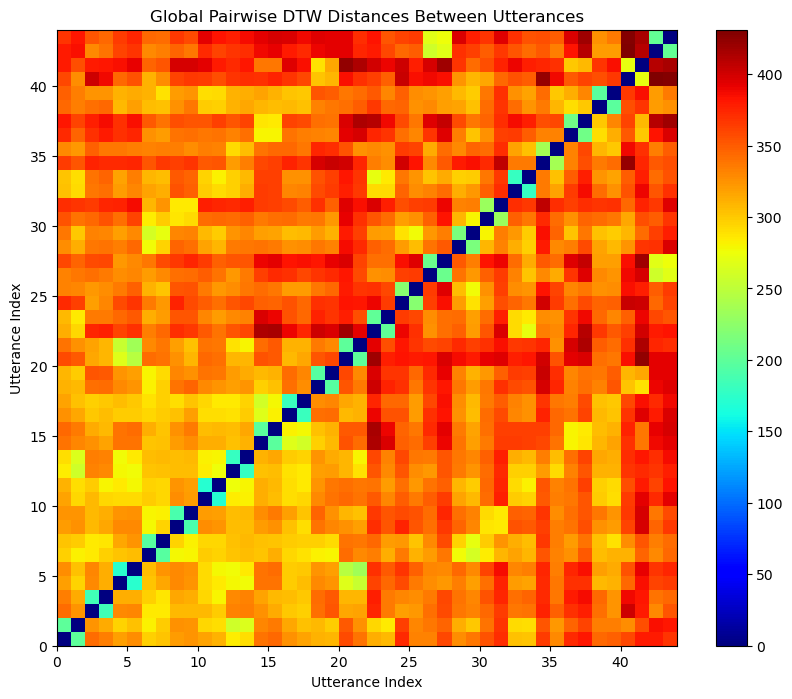

In [25]:
def euclidean_distance(x, y):
    return np.linalg.norm(x - y)


num_utterances = len(mfcc_utterances) # 44 in our case
global_distance = np.zeros((num_utterances, num_utterances))

for i in range(num_utterances):
    for j in range(i+1, num_utterances):  # No need to compute when j <= i
        x = mfcc_utterances[i]
        y = mfcc_utterances[j]

        N = len(x)
        M = len(y)
        LD = np.zeros((N, M))
        for _i in range(N):
            for _j in range(M):
                LD[_i, _j] = euclidean_distance(x[_i], y[_j])
        d, LD, AD, path = dtw(mfcc_utterances[i], mfcc_utterances[j], LD)
        global_distance[i, j] = d
        global_distance[j, i] = d

# Plotting the pairwise distances
plt.figure(figsize=(10, 8))
plt.pcolormesh(global_distance, cmap='jet')
plt.colorbar()
plt.title('Global Pairwise DTW Distances Between Utterances')
plt.xlabel('Utterance Index')
plt.ylabel('Utterance Index')
plt.show()

### Within vs. Across Digit Comparison: 
Examine the distance matrix and the dendrogram. Distances within the same digit (utterances of the same word by different speakers) should be smaller compared to distances across different digits. This pattern indicates that the DTW algorithm can capture the similarity between utterances of the same digit well, despite speaker variations.

### Hierarchical Clustering: 
The dendrogram should reveal clusters that correspond to different digits, demonstrating that the global distances computed via DTW serve as a meaningful measure of similarity between speech utterances. The presence of well-defined clusters for each digit, even across different speakers, would support the effectiveness of using MFCC features and DTW in speech recognition tasks.

### Class Stability: 
If clusters in the dendrogram correspond closely to specific digits and are consistent across different speakers, it suggests that the MFCC features, along with the DTW distance measure, provide a stable representation of spoken words that is relatively speaker-independent.

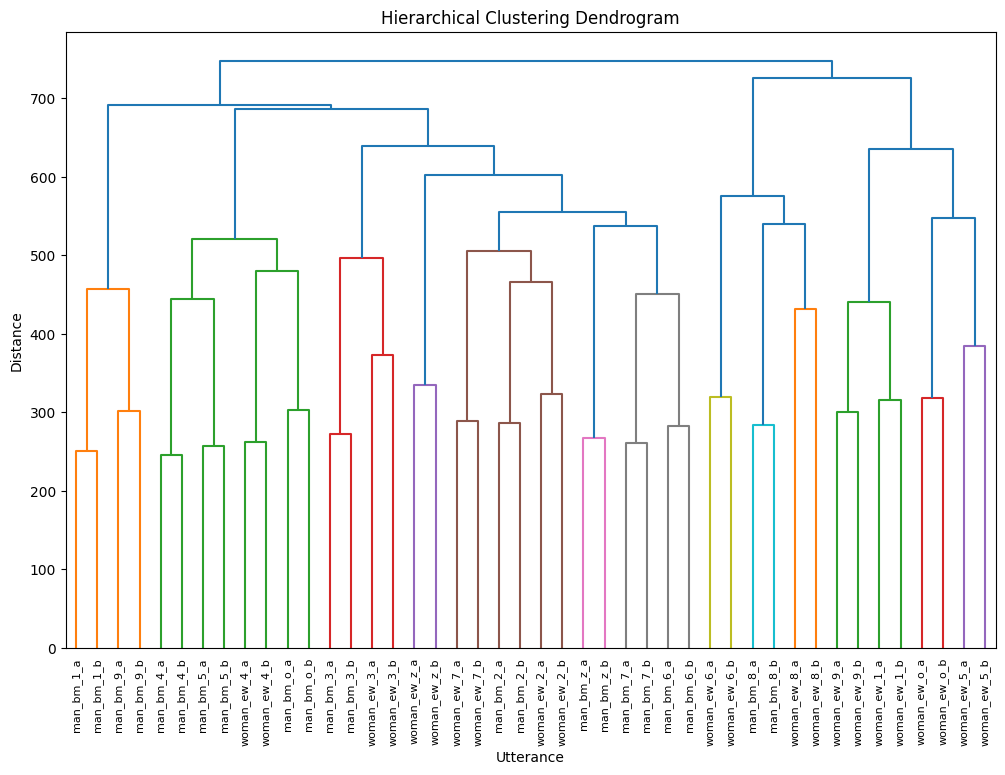

In [28]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(global_distance, method='complete')

plt.figure(figsize=(12, 8))
dendrogram(Z, labels=tidigit2labels(data), leaf_rotation=90, leaf_font_size=8)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Utterance')
plt.ylabel('Distance')
plt.show()